# Importing stuffs

In [1]:
from scipy.signal import convolve2d
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [129]:
originalImg = np.asarray(Image.open("../sampleImage/robert.jpg"))
#originalImg = Image.ROTATE_90
#originalImg = cv2.resize(originalImg,(1500,2000))

In [45]:
def plot_img(img,title="title"):
    plt.imshow(img,cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()
    
def plot_countour(img,title="titlr"):
    plt.contourf(img,cmap="coolwarm")
    plt.title(title)
    plt.colorbar()
    plt.show()

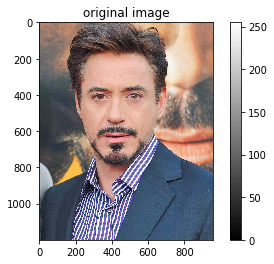

In [130]:
plot_img(originalImg,title="original image")

# Some image processing and minipulation using opencv

### Gaussian blur using opencv

In [132]:
%%time
gausianBlurImg = cv2.GaussianBlur(originalImg,(31,31),10)

CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 63.5 ms


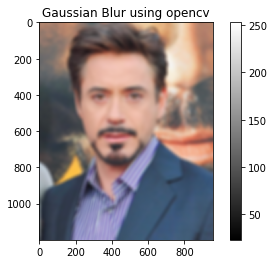

In [133]:
plot_img(gausianBlurImg,title="Gaussian Blur using opencv")

### Applying some filters using opencv

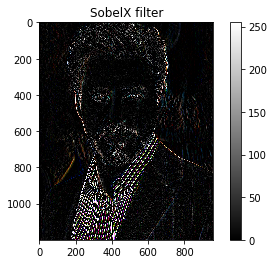

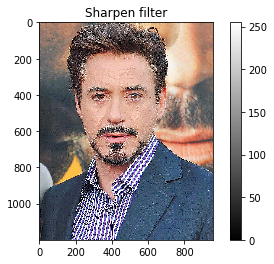

In [134]:
sharpen = np.array((
	[0, -1, 0],
	[-1, 5, -1],
	[0, -1, 0]), dtype="int")

sobelX = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")


plot_img(cv2.filter2D(originalImg,-1,sobelX),title="SobelX filter")
plot_img(cv2.filter2D(originalImg,-1,sharpen),title="Sharpen filter")

# Image to sketch step by step using just numpy.

- note:- 

## 1. Converting RGB image to Grayscale image

- Steps to convert RGB image to Grayscale
	* RGB weights = [0.2126*R,0.7152*G,0.0722*B]
	* We take the dot product of each channel values with rgb weigths
	* The weigths is used to correct the perceptual luminance of the channels

In [135]:
def RGB2GRAY(img):
    if len(np.squeeze(img).shape) == 2:
        print("already in grayscale")
        return img
    else:
        rgb_weights = np.array([0.2126,0.7152,0.0722])
        return np.dot(img[...,:3],rgb_weights)

    

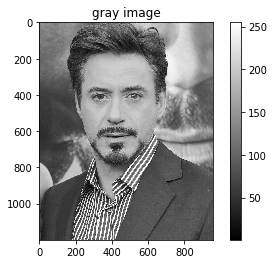

CPU times: user 484 ms, sys: 477 µs, total: 484 ms
Wall time: 483 ms


In [136]:
%%time
grayImage = RGB2GRAY(originalImg)
plot_img(grayImage,"gray image")

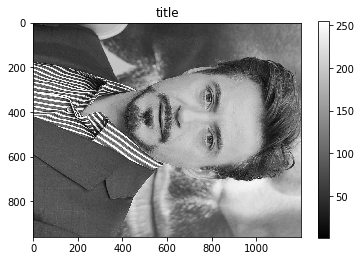

In [137]:
rotatedImg = np.rot90(grayImage,-1)
plot_img(rotatedImg,title="title")

## 2. Inverting an Image.

- step to invert the Grayscale/RGB image i.e convert the image to negative image.
    * Subtract each pixel value from the maximum pixel value from the image.
    * max(img) - img where img is a numpy.ndarray
    

In [121]:
def invert_image(img):
    return img.max() - img

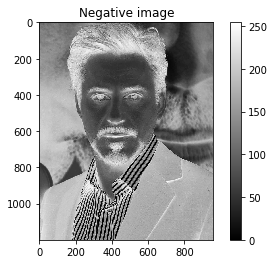

CPU times: user 446 ms, sys: 8.36 ms, total: 454 ms
Wall time: 452 ms


(1200, 960)

In [138]:
%%time
negativeImage = invert_image(grayImage)
plot_img(negativeImage, title="Negative image")
negativeImage.shape

## 3. Applying Gaussian Blur to negative/inverted image.

- Steps to blurr/smooth an image using gaussian filter.
    * Generate a Gaussian Kernel/filter(a square matrix) of given size.
    * Normalize pixel value of the inverted/negative image with in the range of $(0,1)$.
    * Convolve the kernel/filter with the normalized image.
    * After convolution operation on image we again denormalize it in range $(0,255)$

### Generating gaussian kernel.

- we create a gaussian kernel/filter(square matrix) using Gaussian distribution function.
- the Gaussian aka Normal distribution function is given as:

    $\small f(x,\mu , \sigma )=\frac{1}{\sigma \sqrt{2\pi}}\; e^{\frac{-(x- \mu)^{2}}{2\sigma ^{2}}}$
    
    Where,

    $x$ is the variable

    $\mu$ is the mean

    $\sigma$ is the standard deviation

In [90]:
def gaussian_distribution(x,mu,sigma):
    return 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-np.power((x - mu) / sigma, 2) / 2)

def gausianKernel(size,sigma=1,mu=0):
    kernel_1d = np.linspace(-(size//2),size//2,size)
    kernel_1d = gaussian_distribution(kernel_1d,mu,sigma)
    
    kernel_2d = np.outer(kernel_1d.T,kernel_1d)
    kernel_2d *= 1.0/kernel_2d.max() 
    return kernel_2d.astype(np.float32)

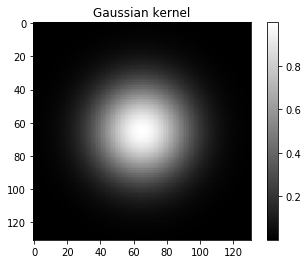

CPU times: user 415 ms, sys: 8.24 ms, total: 424 ms
Wall time: 423 ms


In [91]:
%%time
plot_img(gausianKernel(131,sigma=20),"Gaussian kernel")
#gausianKernel(3,1.2)

### Convolving image with kernel 

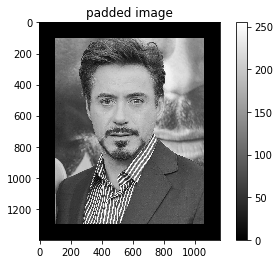

In [139]:
def pad_image(img,pad_width=1):
    '''Padding for just grayscale images'''
    padded_img = np.zeros((img.shape[0] + pad_width*2, img.shape[1]+pad_width*2))
    padded_img[pad_width:-pad_width,pad_width:-pad_width] = img
    return padded_img

plot_img(pad_image(grayImage,pad_width=100),"padded image")

In [140]:
def normalize_img(img,range_end = 1):
    '''range end cannot be 0'''
    return (img/img.max())*range_end

In [141]:
def conv2D(img,kernel):
    '''Naive approach to convolve the image with filter. Takes hell lot of time'''
    kernel_size = kernel.shape[0]
    convolved_output = np.zeros_like(img)
    
    padded_image = pad_image(img,pad_width=kernel_size-2)
    
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            convolved_output[y,x] = (kernel * padded_image[y:y+kernel_size,x:x+kernel_size]).sum()
            
    return convolved_output    
    

#### using naive approach

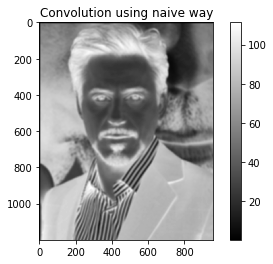

CPU times: user 12 s, sys: 1.81 ms, total: 12 s
Wall time: 12 s


In [142]:
%%time
gaussian_kernel = gausianKernel(15,sigma=5)
image = normalize_img(negativeImage)
plot_img(conv2D(image,gaussian_kernel),"Convolution using naive way")

#### using opencv filter2D method to convolve image at ligthning speed

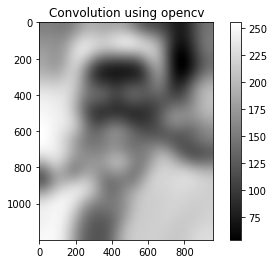

CPU times: user 614 ms, sys: 15.7 ms, total: 630 ms
Wall time: 626 ms


In [150]:
%%time
kernel = gausianKernel(221,sigma=50)
blurNegative = cv2.filter2D(negativeImage,-1,kernel)
plot_img(normalize_img(blurNegative,range_end=255.0),"Convolution using opencv")

## 4.Blending grayscale image with blurred negative image.

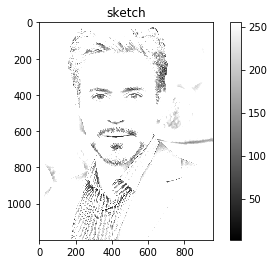

Name the image:  robert22150


True

In [151]:
def dodge(negative_blur,grayimage): 
    result = grayimage/((1.0 - negative_blur)+10e-12)
    result[result>1.0] = 1.0
    result = normalize_img(result,range_end=255.0)
    return result
blurNegative = normalize_img(blurNegative)
grayImage = normalize_img(grayImage)
#blurGray = normalize_img(blurGray)
Dblend = dodge(blurNegative,grayImage)
plot_img(Dblend,"sketch")
IMName = input("Name the image: ")
cv2.imwrite("../results/"+IMName+".png",Dblend)

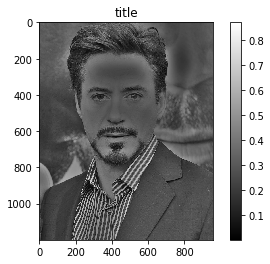

In [152]:
plot_img(blurNegative*grayImage)